In [2]:
# TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
from Functions import total_function_multiprocessing
from time import sleep

list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
list_minutes = [360, 720, 1440, 1440*2, 1440*3]
list_event_buy_volume = [0.65, 0.75, 0.85, 0.9]
list_event_volume = [6,10,15,20,30,50]
n_processes = 8
analysis_timeframe=6.5

LOAD_DATA = False
UNLOCK = True
n_iterations = 2

for i in range(n_iterations):
    if UNLOCK:
        shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, analysis_timeframe)
    iterazione = i+1
    msg=f'{iterazione}/{n_iterations} COMPLETED'
    print(msg)

    print('sleeping')
    sleep(20)

/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-22-11-2023 does not exist. Making the request to the server..
StatusCode for getting get-benchmarkinfo: 200
total_combinations :  5880
/Users/albertorainieri/Projects/Personal/analysis/benchmark_json/benchmark-22-11-2023 exists. Loading the file...
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-07-05-2023-0-0.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-07-06-2023-19-49.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-11-06-2023-14-20.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-15-06-2023-14-20.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-19-06-2023-10-45.json
Nothing to retrieve from /Users/albertorainieri/Projects/Personal/analysis/json/data-23-06-2023-08-02.json
Nothing to retrieve from /Users/albe

In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING 
# # INTEGRATION
# from Functions import total_function_multiprocessing
# from time import sleep


# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m']
# #list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_minutes = [360, 720, 1440, 1440*2, 1440*3]
# list_event_buy_volume = [0.85, 0.9]
# list_event_volume = [6]
# n_processes = 8
# analysis_timeframe = 7

# LOAD_DATA = False
# FREE_LOCK = False

# for i in range(1):
#     print(f'ITERATION {i}')
#     if FREE_LOCK:
#         shared_data = total_function_multiprocessing(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA,
#                                                       analysis_timeframe=analysis_timeframe, INTEGRATION=True)
#     sleep(20)
    

In [ ]:
# # TOTAL WRAP ANALYSIS EVENTS MULTIPROCESSING LESS RAM

# from Functions import total_function_multiprocessing_lessRAM
# list_buy_vol = ['buy_vol_5m', 'buy_vol_15m', 'buy_vol_30m', 'buy_vol_60m', 'buy_vol_3h', 'buy_vol_6h', 'buy_vol_24h']
# list_vol = ['vol_5m', 'vol_15m', 'vol_30m', 'vol_60m', 'vol_3h', 'vol_6h', 'vol_24h']
# list_minutes = [15, 30, 60, 180, 360, 1440, 1440*3]
# list_event_buy_volume = [0.65, 0.75, 0.85]
# list_event_volume = [4,6,8,12,20]
# n_processes = 8

# SLICE_I = 1
# LOAD_DATA = False
# FREE_LOCK = True

# if FREE_LOCK:
#     shared_data = total_function_multiprocessing_lessRAM(list_buy_vol, list_vol, list_minutes, list_event_buy_volume, list_event_volume, n_processes, LOAD_DATA, SLICE_I)

# import os
# duration = 2  # seconds
# freq = 440  # Hz
# os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))


In [4]:
# # DOWNLOAD AND SHOW NESTED OUTPUT FROM TOTAL MULTIPROCESSING
# ONLY GROUP_COINS = TRUE
from Functions import nested_download_show_output
from datetime import datetime
import pandas as pd
pd.set_option('display.max_rows', None)

# minimum_event_number_list MUST BE a list IN REVERSE ORDER
minimum_event_number_list = [200,100,75]
minimum_coin_number = 10
mean_threshold = 0.8
lb_threshold = -15
frequency_threshold = 1
best_coins_volatility = 1
#early_validation = datetime(2023,9,20)
early_validation = False
group_coins=True
std_multiplier = 4

output, info = nested_download_show_output(minimum_event_number_list=minimum_event_number_list, minimum_coin_number=minimum_coin_number,
                                      mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold, group_coins=group_coins,
                                      best_coins_volatility=best_coins_volatility, early_validation=early_validation, std_multiplier=std_multiplier)

df = pd.DataFrame(output).transpose()
df.sort_values(by=['mean'], ascending=False)

Download completed in 6.87 seconds
There are 3 keys for mininum_event_number: 200
There are 13 keys for mininum_event_number: 100
There are 19 keys for mininum_event_number: 75


,mean,std,n_coins,n_events,upper_bound,lower_bound,frequency/month
buy_vol_3h:0.85/vol_30m:20/timeframe:4320,1.599783,3.434565,31.0,81.0,5.034348,-1.834783,15.88
buy_vol_60m:0.85/vol_30m:30/timeframe:1440,1.358235,3.106275,33.0,84.0,4.464510,-1.748039,16.05
buy_vol_30m:0.85/vol_60m:20/timeframe:2880,1.319608,4.008235,35.0,78.0,5.327843,-2.688627,15.00
buy_vol_6h:0.75/vol_60m:20/timeframe:1440,1.279846,4.105846,48.0,95.0,5.385692,-2.826000,18.39
buy_vol_3h:0.85/vol_15m:20/timeframe:1440,1.193800,3.090400,62.0,193.0,4.284200,-1.896600,35.74
buy_vol_3h:0.85/vol_60m:10/timeframe:2880,1.170962,2.983846,35.0,96.0,4.154808,-1.812885,18.11
buy_vol_3h:0.85/vol_60m:10/timeframe:1440,1.140192,2.839808,35.0,103.0,3.980000,-1.699615,19.43
buy_vol_3h:0.85/vol_15m:30/timeframe:1440,1.075797,2.681449,46.0,119.0,3.757246,-1.605652,22.59
buy_vol_3h:0.75/vol_30m:30/timeframe:720,1.061121,4.140862,78.0,183.0,5.201983,-3.079741,34.75
buy_vol_60m:0.75/vol_3h:15/timeframe:1440,1.052394,4.533662,52.0,87.0,5.586056,-3.481268,16.95


In [ ]:
# DOWNLOAD AND SHOW OUTPUT FROM TOTAL MULTIPROCESSING
# GROUP_COINS = TRUE
# from Functions import download_show_output
# import pandas as pd
# from datetime import datetime
# pd.set_option('display.max_rows', None)

# minimum_event_number = 100
# minimum_event_number_list = [minimum_event_number]
# minimum_coin_number = 5
# mean_threshold = 0.5
# lb_threshold = -15
# frequency_threshold = 2
# group_coins = True
# best_coins_volatility = 1
# std_multiplier = 4
# early_validation = datetime(2023,9,15)
# #early_validation = False

# output, info = download_show_output(minimum_event_number=minimum_event_number, minimum_coin_number=minimum_coin_number,
#                                       mean_threshold=mean_threshold, lb_threshold=lb_threshold, frequency_threshold=frequency_threshold, early_validation=early_validation,
#                                        group_coins=group_coins, best_coins_volatility=best_coins_volatility, std_multiplier=std_multiplier)
# df = pd.DataFrame(output).transpose()
# df.sort_values(by=['mean'], ascending=False)
# #df.sort_values(by=['lower_bound'], ascending=False)

There are 0 event_keys that are in the riskmanagement configuration
There are 0 event_keys that have been discarded in the riskmanagement configuration


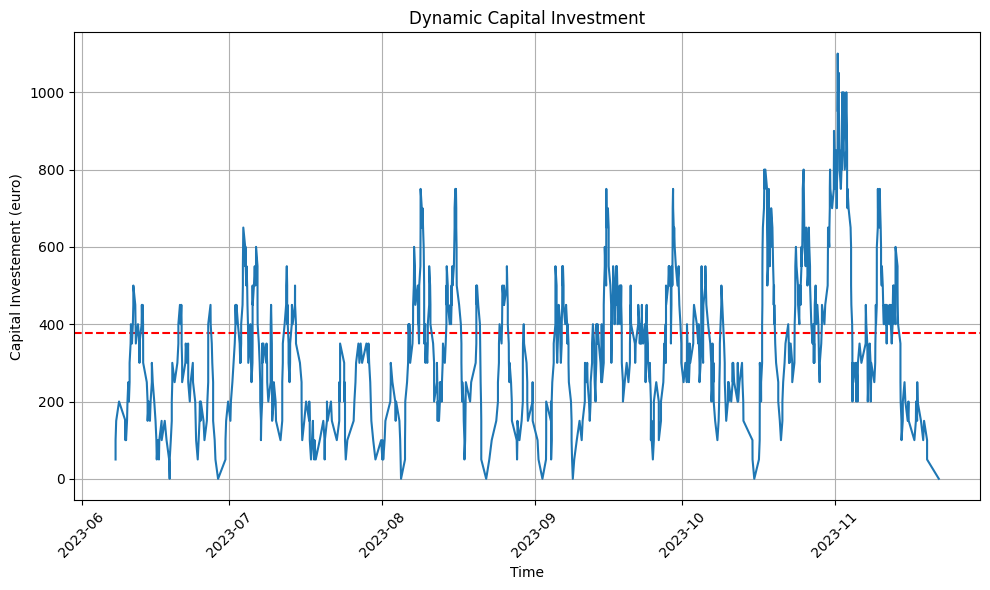

In [8]:
from Functions import check_investment_amount
check_investment_amount(info, output, investment_amount=50)

In [5]:
key = 'buy_vol_30m:0.75/vol_60m:15/timeframe:1440/vlty:3'

In [9]:
from Functions import getTimeseries
response = getTimeseries(info, key, check_past=1440, look_for_newdata=True, plot=False)

File exists, Download from local: /Users/albertorainieri/Projects/Personal/analysis/timeseries_json/buy_vol_30m_0.75_vol_60m_15_timeframe_1440_vlty_3.json
Status Code is :  200
All data have been downloaded
30 new events for buy_vol_30m:0.75/vol_60m:15/timeframe:1440/vlty:3


In [ ]:
from Functions import plot_live_timeseries
risk_management_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-9-27-[50, 35, 25, 15, 5]-3-212.json"
plot_live_timeseries(risk_management_path, filter_live=False, filter_best=50)

In [ ]:
from Functions import infoTimeseries
#key = 'buy_vol_5m:0.65/vol_24h:8/timeframe:4320/vlty:1'
timeseries_info = infoTimeseries(info, key)
timeseries_info


In [ ]:
# ANALYZE RISKMANAGEMENT FOR ONLY 1 KEY
pd.set_option('display.max_colwidth', None)

from Functions import RiskManagement
import pandas as pd
pd.set_option('display.max_rows', None)
key = 'buy_vol_3h:0.75/vol_30m:30/timeframe:720'
df1, df2, best_risk_key, optimized_riskconfiguration_results = RiskManagement(key, investment_per_event=100, early_validation=False)
df1 = df1.sort_values(by=['mean'], ascending=False)
df2 = df2.sort_values(by=['events'], ascending=True)

#result = pd.concat([df1, df2], axis=0)
print(df2)
df1

In [8]:
# ANALYZE THE RISKMANAGEMENT OF ALL KEYS FROM INFO 
from Functions import RiskConfiguration
optimized_gain_threshold = 0
mean_gain_threshold = 0.8
DISCOVER=True

riskmanagement_conf = (minimum_event_number_list, minimum_coin_number, mean_threshold, lb_threshold, frequency_threshold, group_coins, best_coins_volatility, std_multiplier, early_validation)
df, none_riskmanagement_path  = RiskConfiguration(info, riskmanagement_conf, optimized_gain_threshold, mean_gain_threshold, DISCOVER=DISCOVER)
df

22 keys will be analyzed in terms of risk configuration
buy_vol_3h:0.85/vol_30m:10/timeframe:1440
ITERATION 1 has started
File exists, Download from local: /Users/albertorainieri/Projects/Personal/analysis/timeseries_json/buy_vol_3h_0.85_vol_30m_10_timeframe_1440.json
Status Code is :  200
209 new events for buy_vol_3h:0.85/vol_30m:10/timeframe:1440
File exists, Download from local: /Users/albertorainieri/Projects/Personal/analysis/timeseries_json/buy_vol_3h_0.85_vol_30m_10_timeframe_1440.json
Status Code is :  200
All data have been downloaded
1 new events for buy_vol_3h:0.85/vol_30m:10/timeframe:1440
Number of combinations 384
There is only one JSON associated with buy_vol_3h_0.85_vol_30m_10_timeframe_1440
Timeseries has been downloaded


AssertionError: Events Timeseries Json: 210 -- Event Analysis Json: 226 -- buy_vol_3h:0.85/vol_30m:10/timeframe:1440

In [7]:
from Functions import load_riskconfiguration
another_riskconfiguration = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-11-25-[100, 50, 30, 20]-1-VolTrue-MeanThrsl1-266.json"

#another_riskconfiguration = None

df = load_riskconfiguration(another_riskconfiguration)
df

Total events per month on average: 107
Optimized gain each month (percentage) for each event: 0.04067251401869159 euro with investment amount 100 euro per event
Optimized gain each month: 435 euro with investment amount 100 euro per event
Mean gain each month (percentage) for each event: 0.024857971962616823 euro with investment amount 100 euro per event
Mean gain each month: 265 euro with investment amount 100 euro per event
{
    "minimum_event_number": [
        100,
        50,
        30,
        20
    ],
    "minimum_coin_number": 10,
    "mean_threshold": 1,
    "lb_threshold": -15,
    "frequency_threshold": 1,
    "group_coins": false,
    "best_coins_volatility": 1,
    "std_multiplier": 4,
    "early_validation": "2023-11-25T13:09:31.704927",
    "timestamp": "2023-11-25T13:09:31.705052"
}


,keys,golden_zone,step_golden,loss_zone,step_loss,optimized_gain,optimized_std,mean_gain,median_gain,std_gain,frequency,n_events
3,buy_vol_3h:0.75/vol_15m:50/timeframe:1440/vlty:3,0.6,0.05,-0.025,0.05,9.25,23.51,5.57,5.38,17.27,4.32,20
8,buy_vol_30m:0.85/vol_60m:15/timeframe:2880/vlty:4,0.8,0.05,-0.05,0.15,8.98,32.69,3.92,3.50,15.94,7.35,36
9,buy_vol_6h:0.65/vol_3h:20/timeframe:1440/vlty:4,0.2,0.05,-0.025,0.1,6.79,10.69,3.71,3.96,12.59,5.08,22
2,buy_vol_3h:0.75/vol_30m:20/timeframe:1440/vlty:3,0.3,0.15,-0.05,0.15,5.80,20.26,3.59,3.66,14.70,6.71,34
6,buy_vol_60m:0.85/vol_15m:30/timeframe:2880/vlty:6,0.4,0.1,-0.05,0.05,4.05,13.31,2.52,2.56,9.27,8.33,45
1,buy_vol_15m:0.85/vol_60m:15/timeframe:2880/vlty:3,0.6,0.025,-0.05,0.15,3.92,15.36,2.52,2.62,10.35,10.73,54
10,buy_vol_15m:0.85/vol_30m:15/timeframe:4320/vlty:7,0.3,0.025,-0.025,0.15,3.48,8.97,2.19,2.11,5.95,6.44,32
11,buy_vol_15m:0.75/vol_3h:10/timeframe:4320/vlty:7,0.3,0,-0.05,0.025,3.15,6.56,2.36,2.32,3.94,4.00,20
5,buy_vol_60m:0.85/vol_60m:6/timeframe:2880/vlty:6,0.4,0.1,-0.025,0.15,3.04,10.96,2.19,2.23,7.73,11.85,64
0,buy_vol_30m:0.75/vol_60m:15/timeframe:1440/vlty:3,0.6,0.025,-0.025,0.1,2.85,14.90,1.81,1.83,11.26,19.88,106


In [1]:
from Functions import filter_existing_riskconfiguration
import re
file_path = '/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-11-23-[200, 100]-0.5-VolFalse-MeanThrsl0.5-672.json'

mean_gain_threshold = 0.8
filter_existing_riskconfiguration(file_path, mean_gain_threshold)

In [12]:
from Functions import send_riskconfiguration
response = send_riskconfiguration()

Status Code is :  200


Loading analysis.json for both scenarios: OPTIMIZED or not
OPTIMIZED ANALYSIS
Loading data from analysis.json
There is only one JSON associated with buy_vol_30m_0.75_vol_60m_15_timeframe_1440_vlty_3
Timeseries has been downloaded
No need to update optimized_results for buy_vol_30m:0.75/vol_60m:15/timeframe:1440/vlty:3
There is only one JSON associated with buy_vol_30m_0.85_vol_30m_6_timeframe_4320_vlty_2
Timeseries has been downloaded
No need to update optimized_results for buy_vol_30m:0.85/vol_30m:6/timeframe:4320/vlty:2
There is only one JSON associated with buy_vol_60m_0.85_vol_60m_6_timeframe_2880_vlty_6
Timeseries has been downloaded
No need to update optimized_results for buy_vol_60m:0.85/vol_60m:6/timeframe:2880/vlty:6
There is only one JSON associated with buy_vol_3h_0.85_vol_15m_20_timeframe_360_vlty_4
Timeseries has been downloaded
No need to update optimized_results for buy_vol_3h:0.85/vol_15m:20/timeframe:360/vlty:4
There is only one JSON associated with buy_vol_15m_0.85_vo

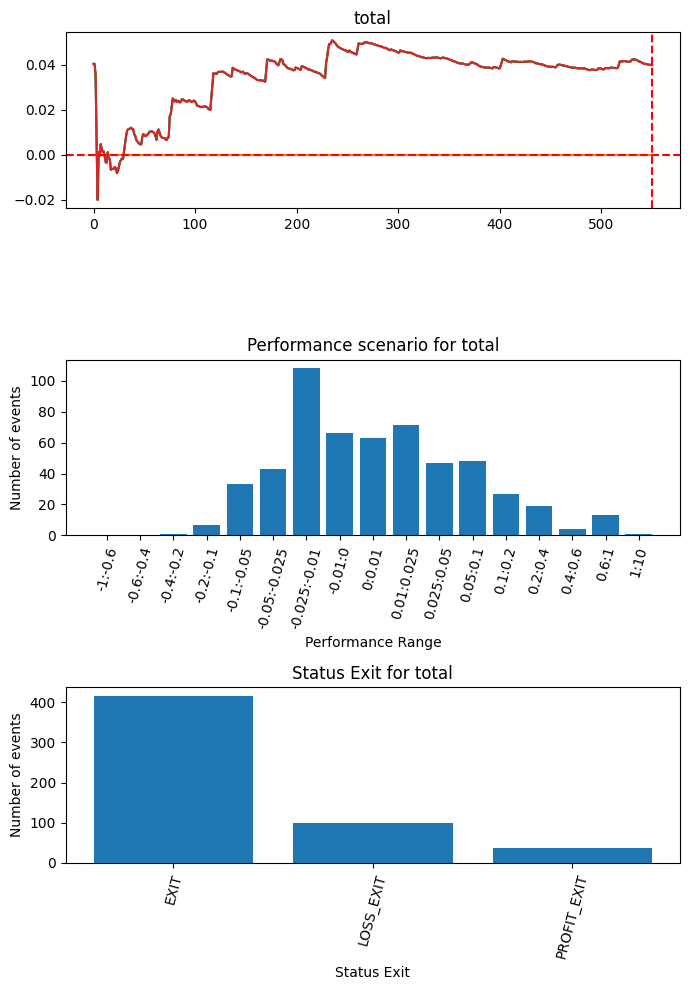

Positive events: 285
Negative events: 266
the profit of the entire timeseries is 3.99% with 551 events
the post profit is nan% with 0 events
Biggest Drop: 48.41 at 2023-11-17T10:32:02.260981
buy_vol_30m:0.75/vol_60m:15/timeframe:1440/vlty:3
Number of events for 106


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


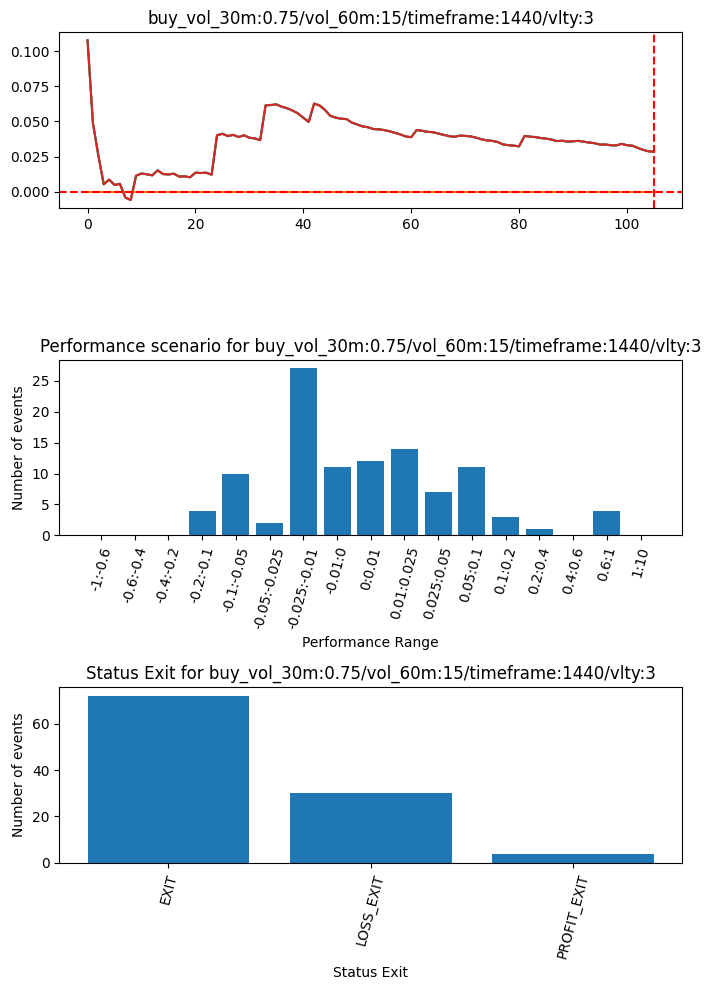

Positive events: 52
Negative events: 54
buy_vol_15m:0.85/vol_60m:15/timeframe:2880/vlty:3
Number of events for 54


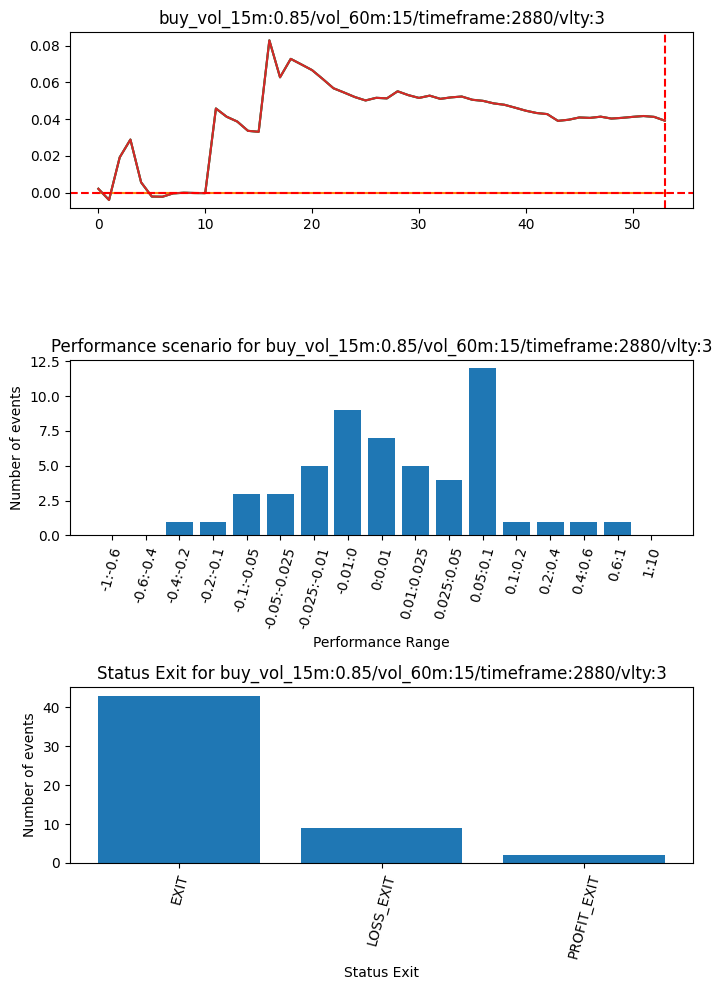

Positive events: 32
Negative events: 22
buy_vol_3h:0.75/vol_30m:20/timeframe:1440/vlty:3
Number of events for 34


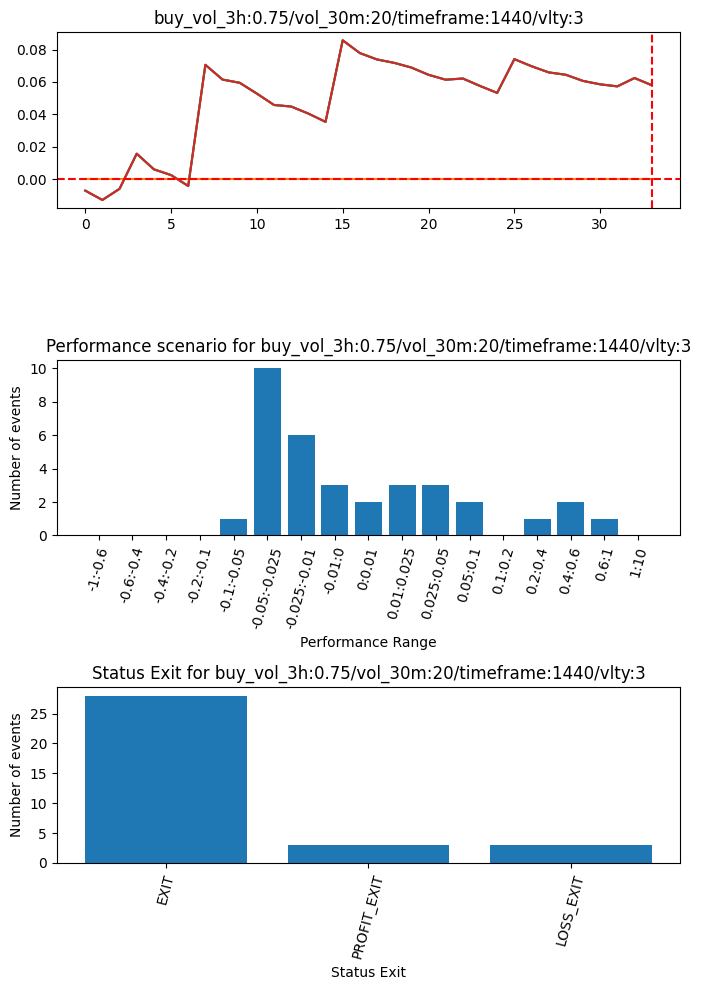

Positive events: 14
Negative events: 20
buy_vol_3h:0.75/vol_15m:50/timeframe:1440/vlty:3
Number of events for 20


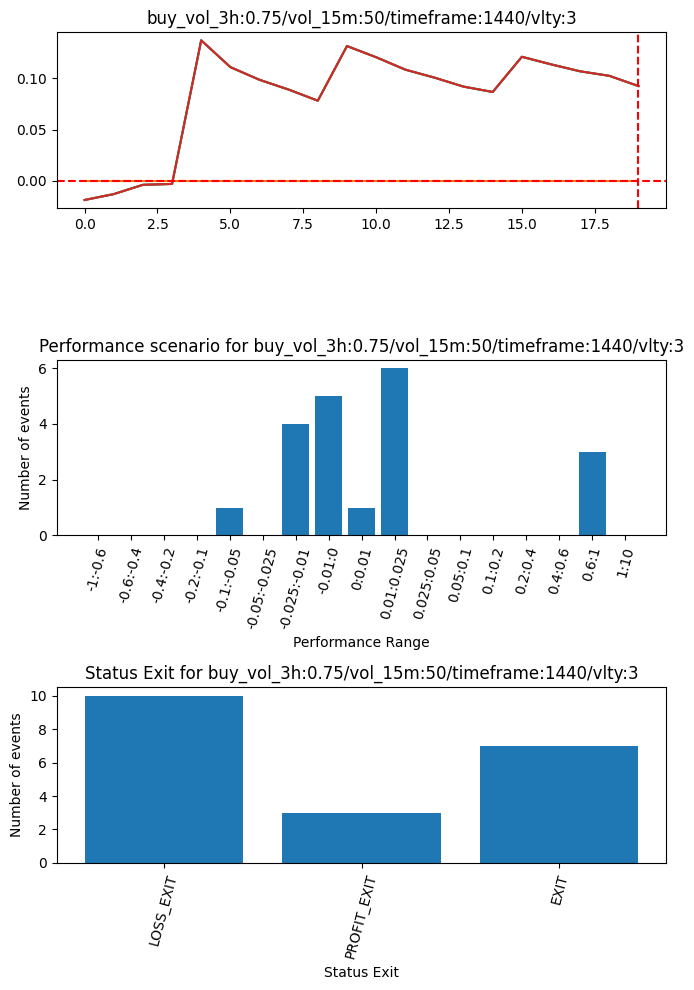

Positive events: 10
Negative events: 10
buy_vol_30m:0.85/vol_30m:6/timeframe:4320/vlty:2
Number of events for 68


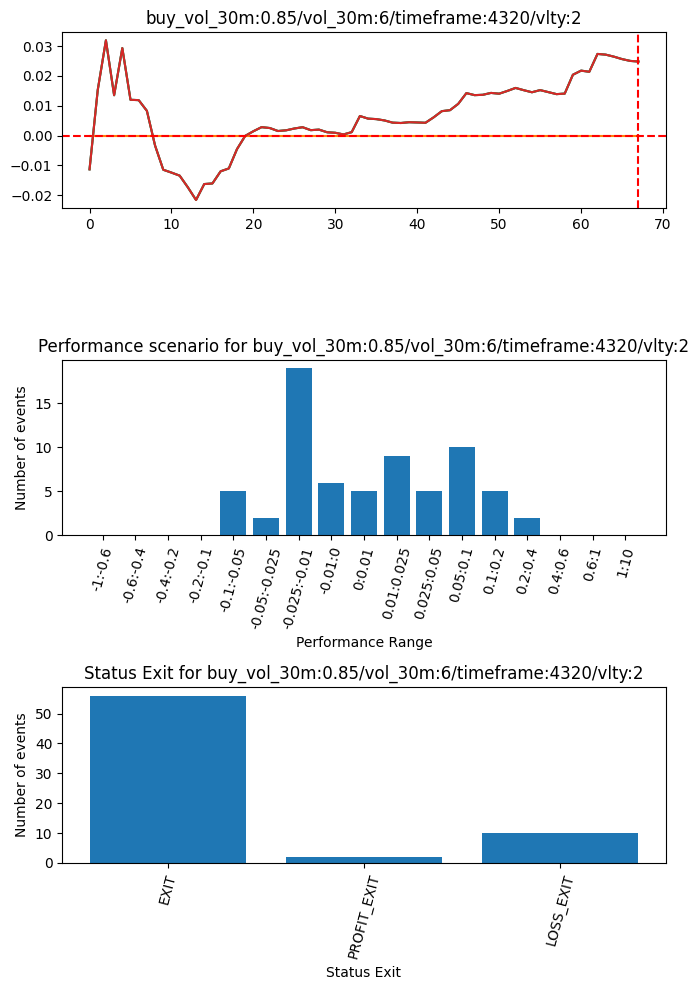

Positive events: 36
Negative events: 32
buy_vol_60m:0.85/vol_60m:6/timeframe:2880/vlty:6
Number of events for 64


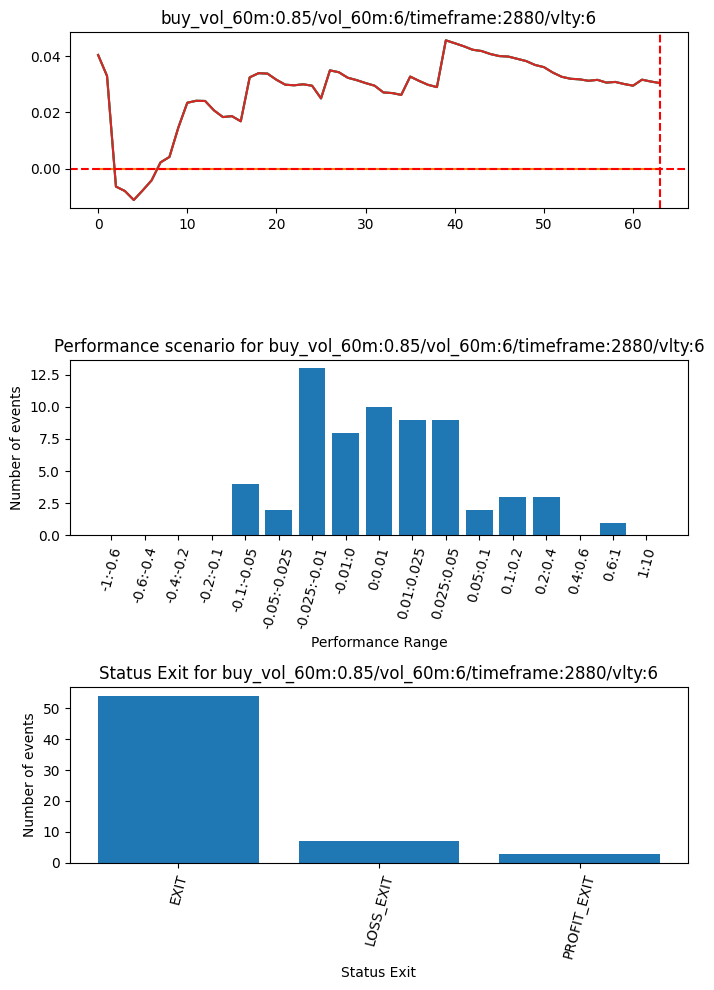

Positive events: 35
Negative events: 29
buy_vol_60m:0.85/vol_15m:30/timeframe:2880/vlty:6
Number of events for 45


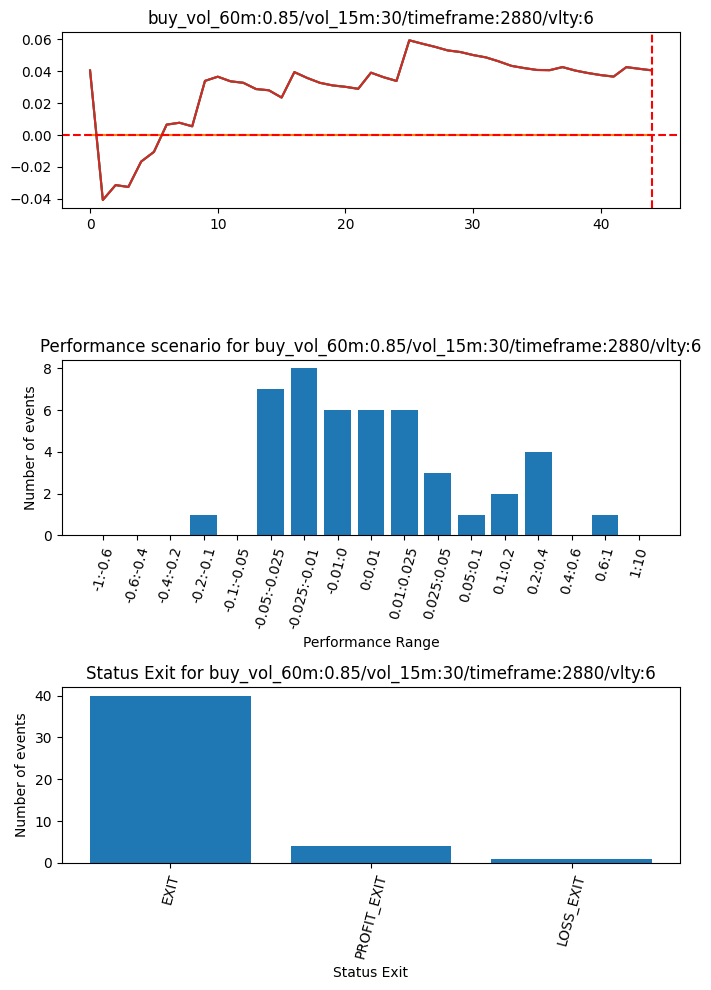

Positive events: 22
Negative events: 23
buy_vol_3h:0.85/vol_15m:20/timeframe:360/vlty:4
Number of events for 50


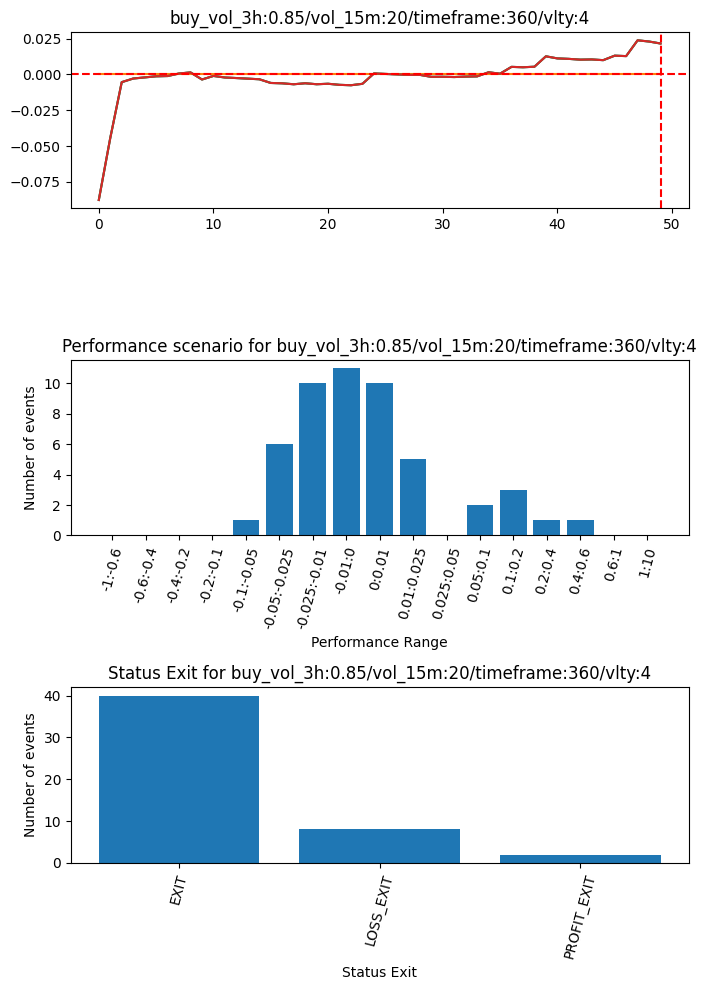

Positive events: 20
Negative events: 30
buy_vol_30m:0.85/vol_60m:15/timeframe:2880/vlty:4
Number of events for 36


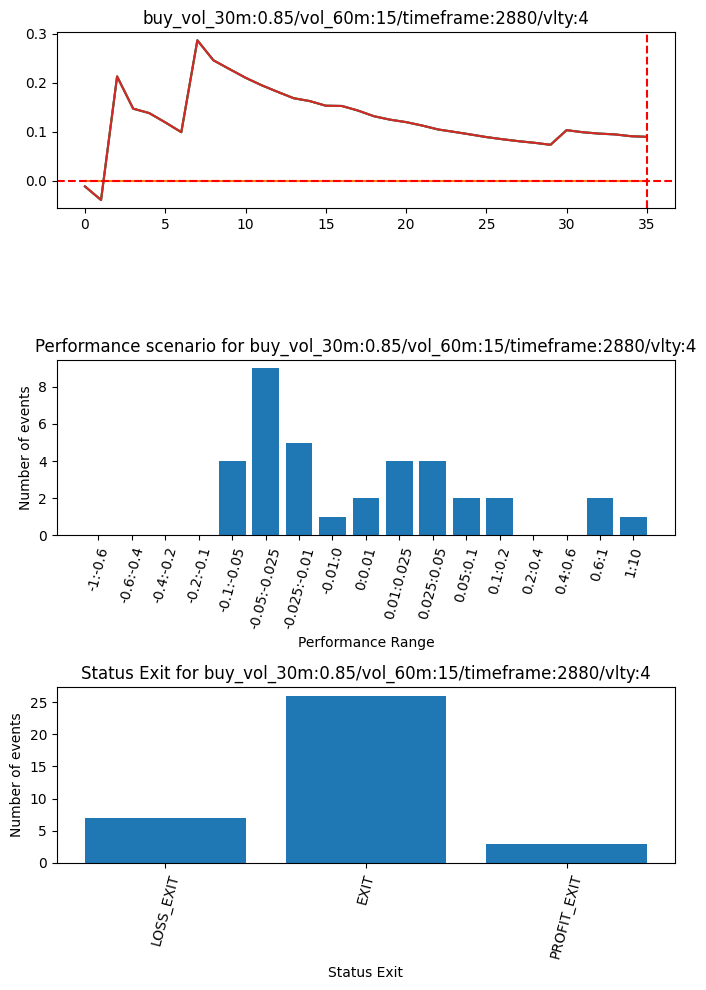

Positive events: 16
Negative events: 20
buy_vol_6h:0.65/vol_3h:20/timeframe:1440/vlty:4
Number of events for 22


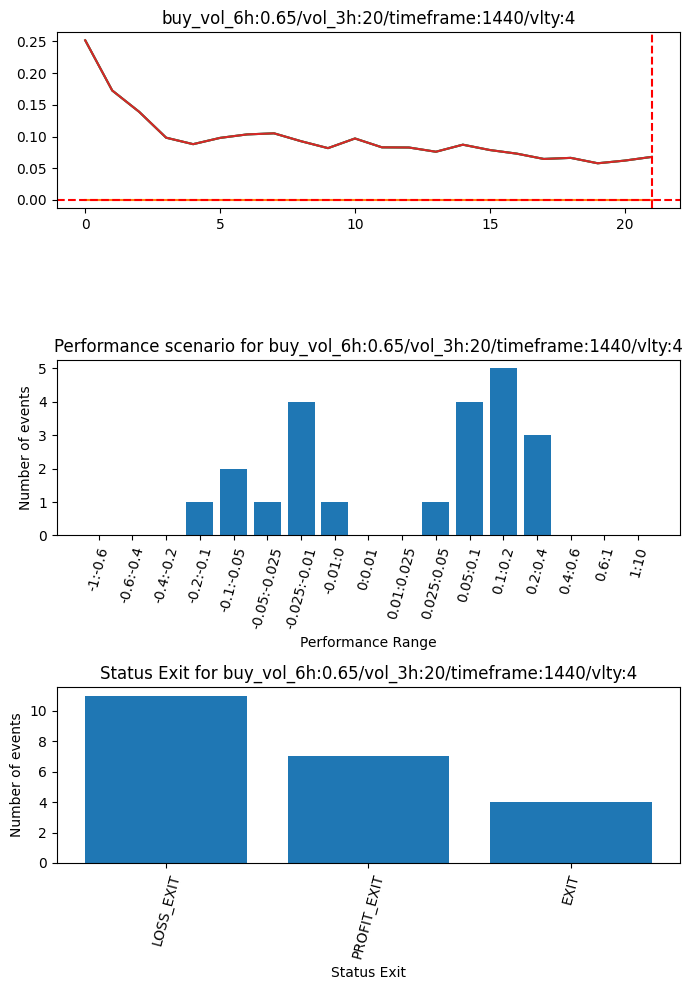

Positive events: 13
Negative events: 9
buy_vol_15m:0.85/vol_30m:15/timeframe:4320/vlty:7
Number of events for 32


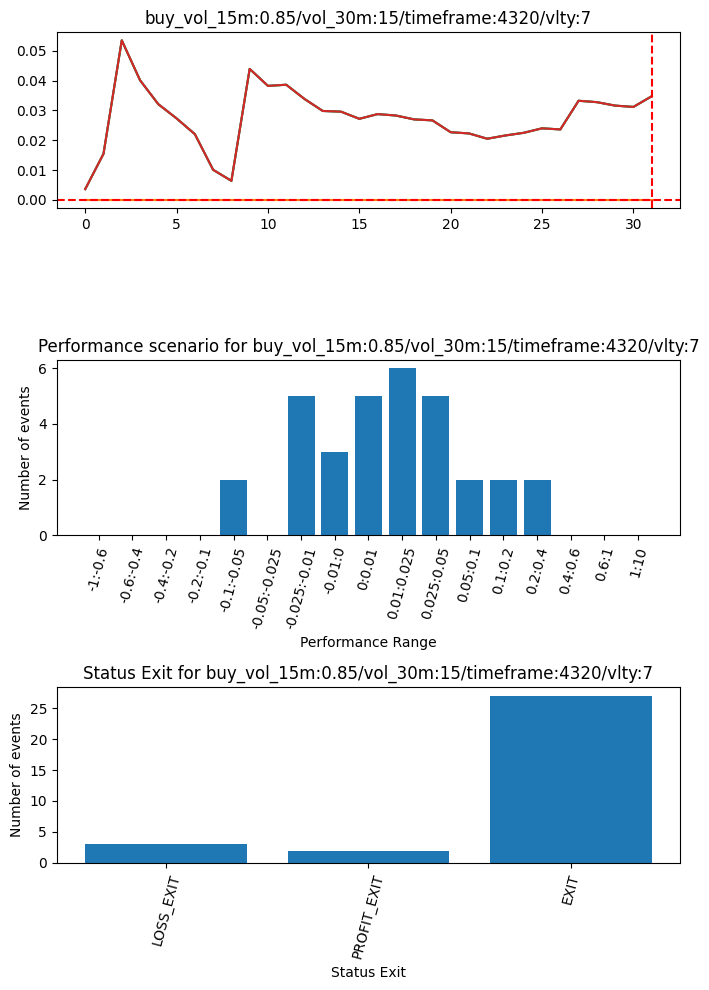

Positive events: 20
Negative events: 12
buy_vol_15m:0.75/vol_3h:10/timeframe:4320/vlty:7
Number of events for 20


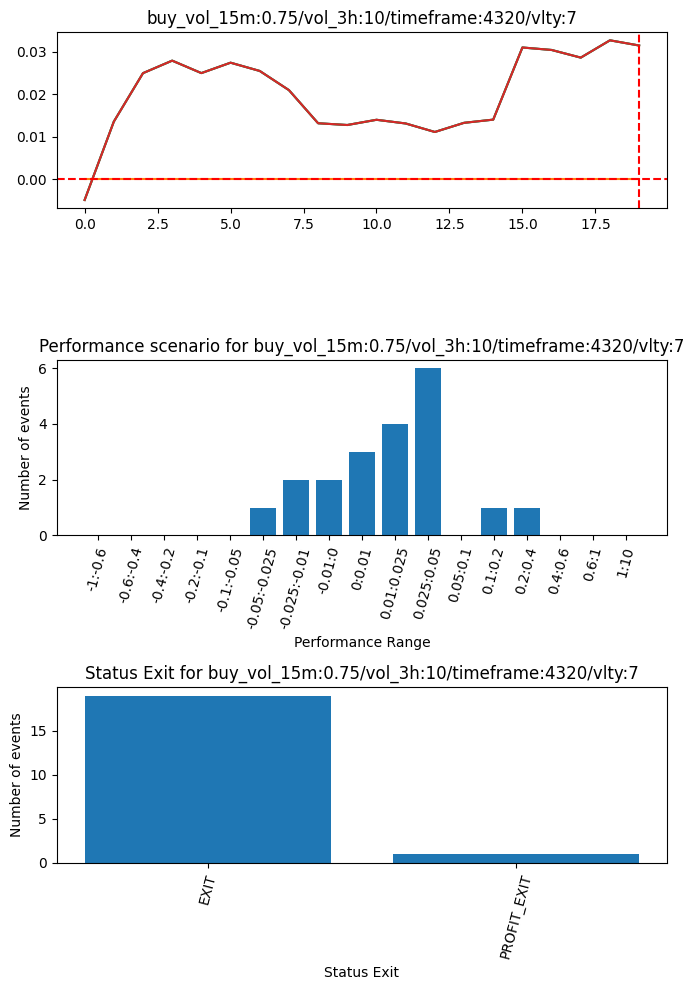

Positive events: 15
Negative events: 5
Positive events: {'total': {'positive': 285, 'negative': 266}, 'buy_vol_30m:0.75/vol_60m:15/timeframe:1440/vlty:3': {'positive': 52, 'negative': 54}, 'buy_vol_15m:0.85/vol_60m:15/timeframe:2880/vlty:3': {'positive': 32, 'negative': 22}, 'buy_vol_3h:0.75/vol_30m:20/timeframe:1440/vlty:3': {'positive': 14, 'negative': 20}, 'buy_vol_3h:0.75/vol_15m:50/timeframe:1440/vlty:3': {'positive': 10, 'negative': 10}, 'buy_vol_30m:0.85/vol_30m:6/timeframe:4320/vlty:2': {'positive': 36, 'negative': 32}, 'buy_vol_60m:0.85/vol_60m:6/timeframe:2880/vlty:6': {'positive': 35, 'negative': 29}, 'buy_vol_60m:0.85/vol_15m:30/timeframe:2880/vlty:6': {'positive': 22, 'negative': 23}, 'buy_vol_3h:0.85/vol_15m:20/timeframe:360/vlty:4': {'positive': 20, 'negative': 30}, 'buy_vol_30m:0.85/vol_60m:15/timeframe:2880/vlty:4': {'positive': 16, 'negative': 20}, 'buy_vol_6h:0.65/vol_3h:20/timeframe:1440/vlty:4': {'positive': 13, 'negative': 9}, 'buy_vol_15m:0.85/vol_30m:15/timefram

,event,mean_series,mean_event,balance,coin,event_key,buy_price,exit_price,timestamp_exit,max_price,...,buy_2h,buy_3h,buy_6h,buy_12h,buy_18h,buy_1d,buy_2d,buy_3d,buy_5d,buy_7d
0,2023-06-07T21:12:02.186826,0.040435,0.040435,1002.63,ALPACAUSDT,buy_vol_60m:0.85/vol_60m:6/timeframe:2880/vlty:6,1.657000e-01,1.724000e-01,2023-06-09T11:36:02.749985,1.747000e-01,...,0.4230,0.3610,0.6060,0.8280,0.4709,0.9424,NaN,NaN,NaN,NaN
1,2023-06-07T21:12:02.186826,0.040435,0.040435,1005.26,ALPACAUSDT,buy_vol_60m:0.85/vol_15m:30/timeframe:2880/vlty:6,1.657000e-01,1.724000e-01,2023-06-09T11:36:02.749985,1.747000e-01,...,0.4230,0.3610,0.6060,0.8280,0.4709,0.9424,NaN,NaN,NaN,NaN
2,2023-06-08T00:17:02.514264,0.035454,0.025492,1006.92,HIFIUSDT,buy_vol_60m:0.85/vol_60m:6/timeframe:2880/vlty:6,3.099000e-01,3.178000e-01,2023-06-09T14:41:02.630541,3.227000e-01,...,0.6930,0.6860,0.5127,0.2560,0.2810,0.7400,NaN,NaN,NaN,NaN
3,2023-06-08T14:11:02.309157,0.005294,-0.085187,1001.38,BIFIUSDT,buy_vol_60m:0.85/vol_60m:6/timeframe:2880/vlty:6,3.956000e+02,3.619000e+02,2023-06-11T06:10:02.609068,4.165000e+02,...,0.9167,0.9367,0.1290,0.4818,0.9400,0.2060,0.5784,NaN,NaN,NaN
4,2023-06-09T21:17:02.299773,-0.020111,-0.121729,993.47,BIFIUSDT,buy_vol_60m:0.85/vol_15m:30/timeframe:2880/vlty:6,4.165000e+02,3.658000e+02,2023-06-11T20:12:02.592229,4.165000e+02,...,0.2700,0.4690,0.2033,0.5430,0.6500,0.1944,0.5244,0.6211,NaN,NaN
5,2023-06-10T05:06:02.778167,0.001224,0.107896,1000.48,SFPUSDT,buy_vol_30m:0.75/vol_60m:15/timeframe:1440/vlty:3,3.318000e-01,3.676000e-01,2023-06-11T00:19:02.264048,3.727000e-01,...,0.2909,0.3890,0.7390,0.2955,0.4690,0.7920,0.4280,0.5000,0.4985,NaN
6,2023-06-10T07:17:02.034454,-0.000573,-0.011350,999.74,SSVUSDT,buy_vol_30m:0.85/vol_30m:6/timeframe:4320/vlty:2,1.674000e+01,1.655000e+01,2023-06-12T16:53:02.407669,1.683000e+01,...,0.4570,0.4570,0.3210,0.4750,0.3680,0.4400,0.6030,0.2660,0.3090,NaN
7,2023-06-10T11:17:02.597657,0.004736,0.041893,1002.46,C98USDT,buy_vol_30m:0.85/vol_30m:6/timeframe:4320/vlty:2,1.289000e-01,1.343000e-01,2023-06-12T20:54:02.307381,1.344000e-01,...,0.4511,0.5020,0.5480,0.2720,0.3380,0.4940,0.5845,0.3900,0.3900,NaN
8,2023-06-10T17:39:02.038875,0.002800,-0.012681,1001.64,GNOUSDT,buy_vol_60m:0.85/vol_60m:6/timeframe:2880/vlty:6,1.104000e+02,1.090000e+02,2023-06-12T08:03:02.042289,1.114000e+02,...,0.4720,0.7140,0.4870,0.3940,0.5510,0.6540,0.3782,0.4780,0.5840,NaN
9,2023-06-10T17:39:02.038875,0.001252,-0.012681,1000.82,GNOUSDT,buy_vol_60m:0.85/vol_15m:30/timeframe:2880/vlty:6,1.104000e+02,1.090000e+02,2023-06-12T08:03:02.042289,1.114000e+02,...,0.4720,0.7140,0.4870,0.3940,0.5510,0.6540,0.3782,0.4780,0.5840,NaN


In [1]:
from Functions import analyzeRiskManagementPerformance

riskmanagement_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-11-25-[100, 50, 30, 20]-1-VolTrue-MeanThrsl1-266.json"
OPTIMIZED=True
DISCOVER=False

event_investment_amount=65


df, biggest_drop, biggest_drop_date, positive_outcome, negative_outcome, PERFORMANCE_SCENARIOS = analyzeRiskManagementPerformance(riskmanagement_path, OPTIMIZED, DISCOVER, event_investment_amount)
import pandas as pd
pd.set_option('display.max_rows', None)
print(f'Positive events: {positive_outcome}')
print(f'Negative events: {negative_outcome}')
print(f'Biggest Drop: {biggest_drop} at {biggest_drop_date}')

df

['buy_vol_15m:0.65/vol_3h:50/timeframe:720/vlty:4', 'buy_vol_5m:0.85/vol_15m:50/timeframe:2880/vlty:4', 'buy_vol_60m:0.65/vol_60m:50/timeframe:1440/vlty:4', 'buy_vol_60m:0.85/vol_30m:10/timeframe:2880/vlty:6', 'buy_vol_60m:0.85/vol_15m:30/timeframe:2880/vlty:6', 'buy_vol_60m:0.75/vol_60m:20/timeframe:720/vlty:6', 'buy_vol_15m:0.85/vol_30m:15/timeframe:2880/vlty:3', 'buy_vol_3h:0.75/vol_60m:15/timeframe:1440/vlty:3', 'buy_vol_60m:0.9/vol_5m:6/timeframe:4320/vlty:2', 'buy_vol_60m:0.65/vol_6h:10/timeframe:4320/vlty:2', 'buy_vol_3h:0.65/vol_24h:6/timeframe:720/vlty:5', 'buy_vol_5m:0.65/vol_60m:30/timeframe:360/vlty:1', 'buy_vol_6h:0.65/vol_30m:10/timeframe:360/vlty:7']
This Risk Configuration has been defined, from a dataset loaded from May 2023 until 2023-09-20T00:00:00
Download completed in 7.02 seconds
There are 0 keys for mininum_event_number: 200
There are 0 keys for mininum_event_number: 100
There are 4 keys for mininum_event_number: 50
There are 5 keys for mininum_event_number: 30
T

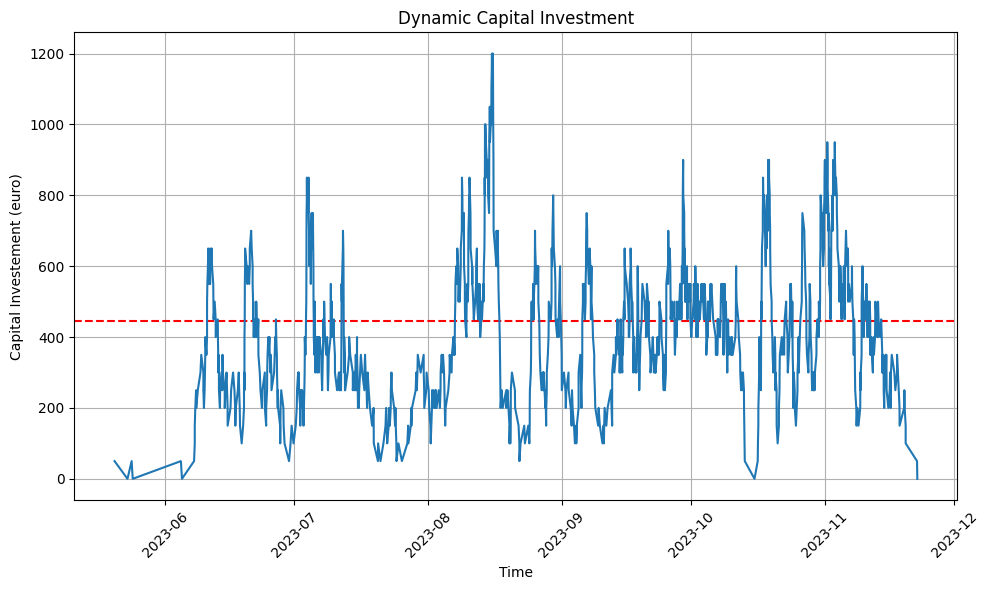

In [4]:
from Functions import check_investment_amount
info=None
output=None
riskmanagement_path = "/Users/albertorainieri/Projects/Personal/analysis/riskmanagement_backup/riskmanagement-2023-9-23-[200, 100, 50, 30, 15]-1-earlyvalidation-4stdmultiplier-VolTrue-476.json"
check_investment_amount(info, output, investment_amount=50, riskmanagement_path=riskmanagement_path)